# Welter



Monday, May 4, 2016  

## Phase of variability.

part 1

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## ASASSN Data from Subo Dong

In [7]:
#! head ../data/photometry/LkCa4.dat

In [8]:
import pandas as pd

The header contains 3 extraneous octothorpes "###".  Read the data just to get the columns.

In [9]:
fn = '../data/photometry/LkCa4.dat'
names = pd.read_csv(fn, delim_whitespace=True, nrows=0).columns[1:]
dat = pd.read_csv(fn, delim_whitespace=True, names=names, header=0, index_col=False)
#dat.head()

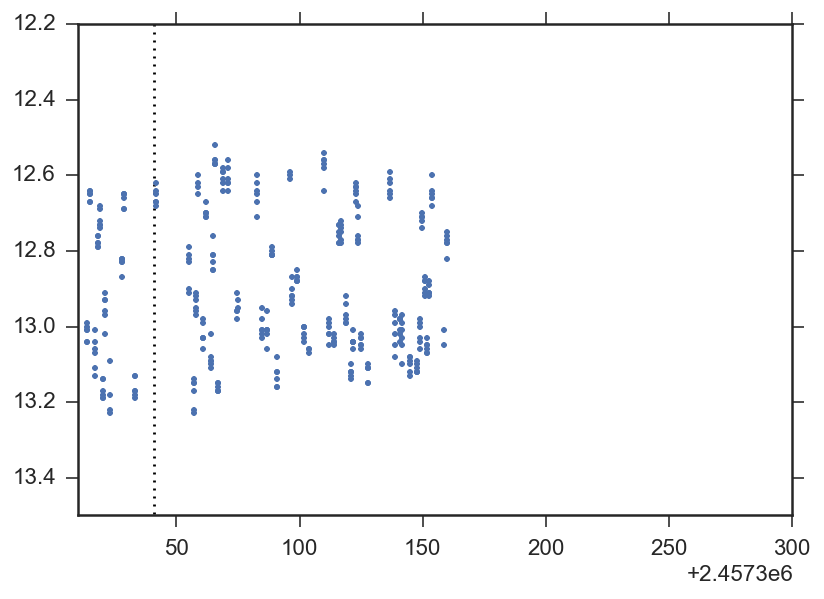

In [10]:
plt.plot(dat.JD, dat.mag, '.')
plt.ylim(13.5, 12.2)
plt.xlim(2457310)#, 2457390)

plt.vlines(2457341.0, 12.2, 13.5, linestyles='dotted')

plt.plot(x, y)

## Model

In [11]:
def lnlike(theta, x, y, yerr):
    A, b0, B, p, lnf = theta
    model = b0 + A*np.sin(2.0*np.pi*(x-B)/p) # + B*np.cos(2.0*np.pi*x/p)
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [12]:
def lnprior(theta):
    A, b0, B, p, lnf = theta
    if (3.3 < p < 3.4) and (0.35 < A < 0.9) and (0 < B < p):
        return 0.0
    return -np.inf

In [13]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [14]:
guess = np.array([0.80,12.9, 2.0, 3.375, -4.0])

In [15]:
ndim, nwalkers = 5, 40
pos = [guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [16]:
inds = (dat.JD > 2457060) 

In [17]:
x = dat.JD[inds]
y = dat.mag[inds]
yerr = dat.mag_err[inds]

In [214]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [215]:
n_samples = 5000

In [216]:
output = sampler.run_mcmc(pos, n_samples)

In [228]:
ws = sampler.chain

In [229]:
ws.shape

(40, 5000, 5)

In [230]:
from matplotlib.ticker import MaxNLocator

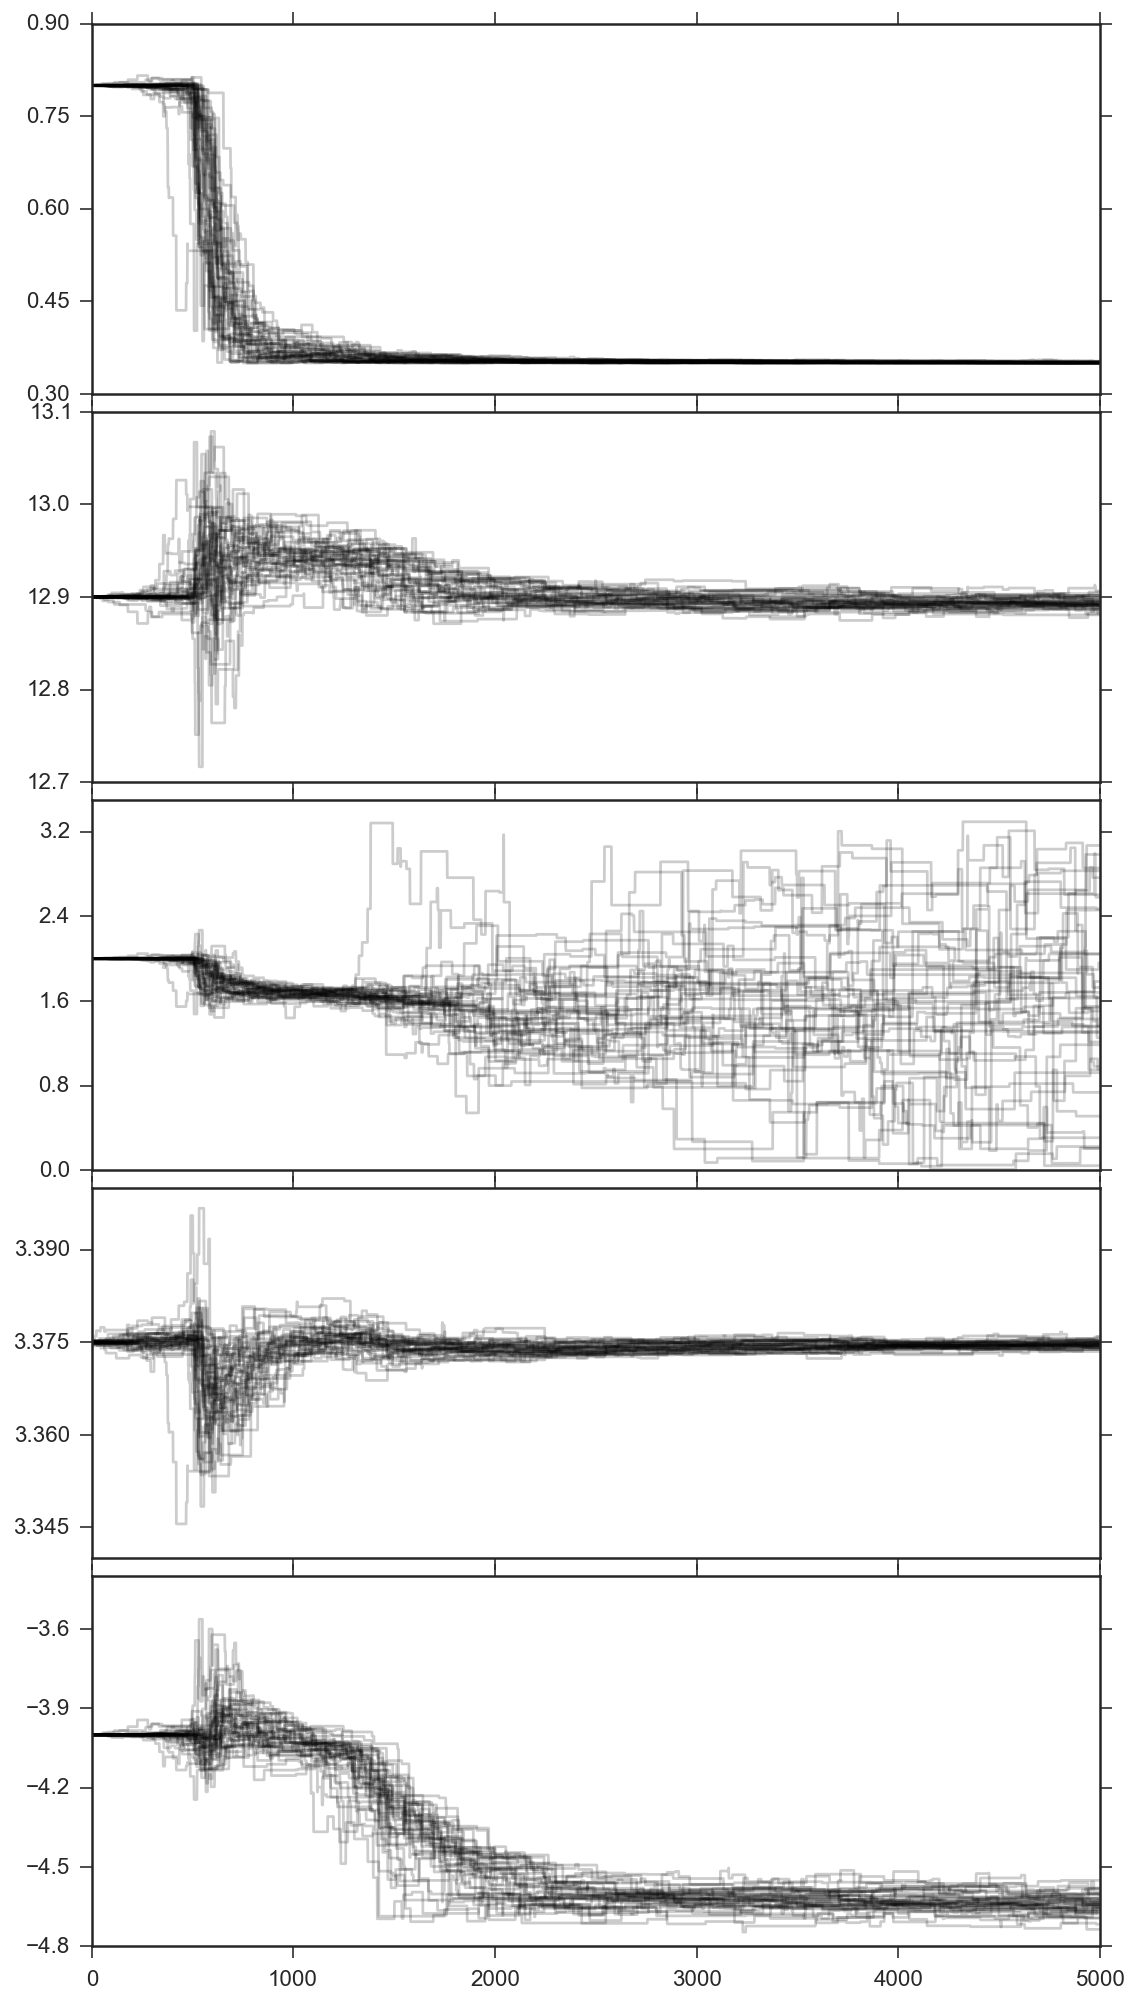

In [231]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 14))
for i in range(0, 5, 1):
    axes[i].plot(ws[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i].set_ylabel(label[i])

#axes[13].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)

In [233]:
sampler.chain.shape

(40, 5000, 5)

In [234]:
samples = sampler.chain[:, 3000:, :].reshape((-1, ndim))

In [235]:
import corner

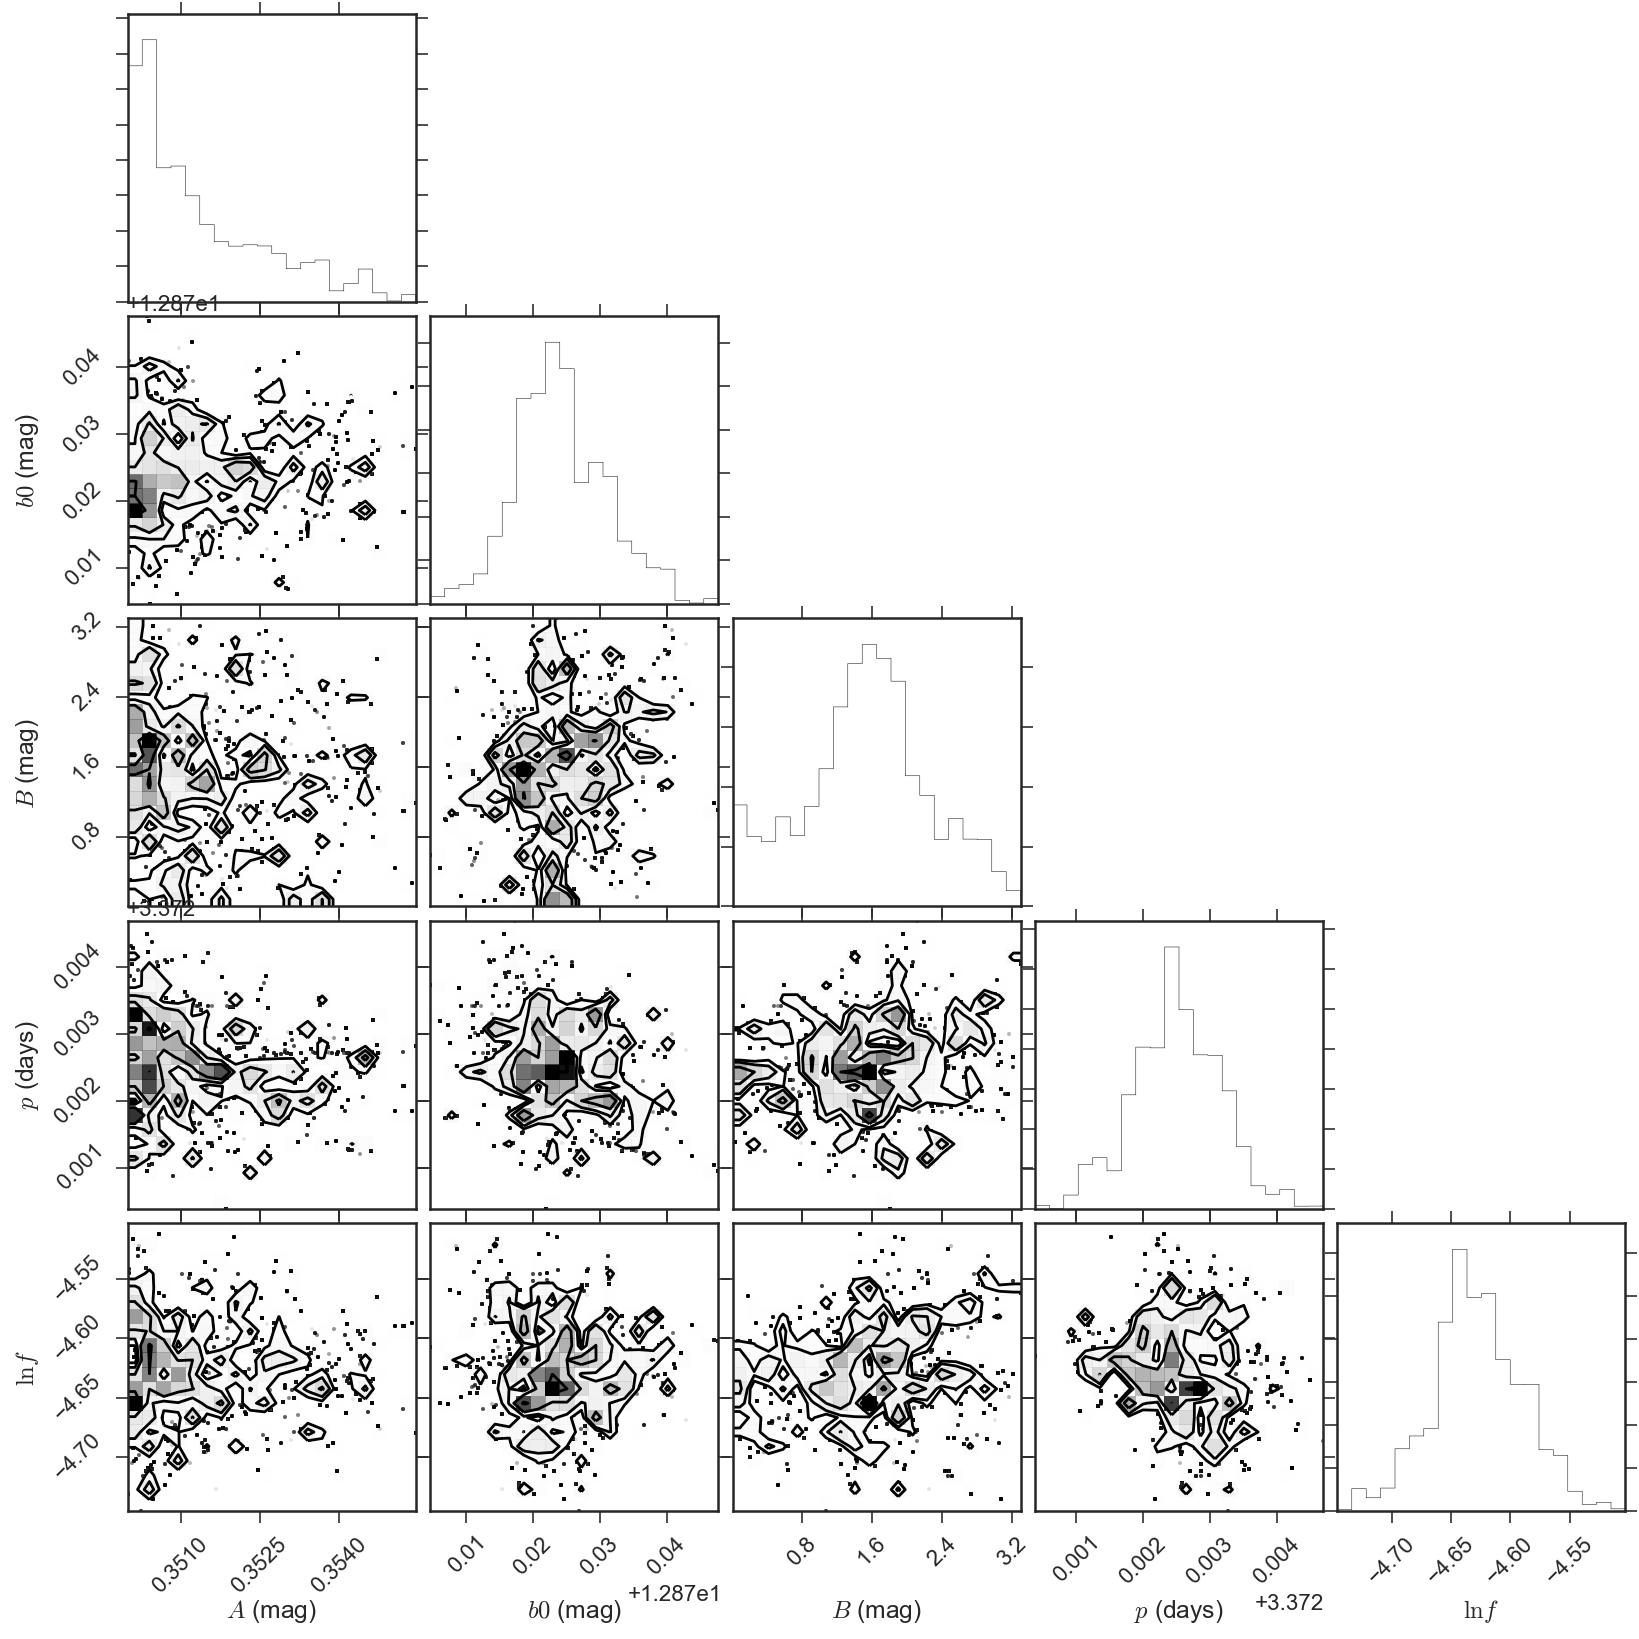

In [236]:
fig = corner.corner(samples, labels=["$A$ (mag)", "$b0$ (mag)", "$B$ (mag)", "$p$ (days)", "$\ln{f}$"])
#fig.savefig("triangle.png")

In [237]:
samples.shape

(80000, 5)

In [238]:
A, b0, B, p, lnf = samples[10000]

In [239]:
x_dense = 2457313.88562 + np.arange(0, 300, 0.1)

In [240]:
x_dense.shape

(3000,)

In [19]:
model = b0 + A*np.sin(2.0*np.pi*(x_dense-B)/p) # + B*np.cos(2.0*np.pi*x/p)

NameError: name 'b0' is not defined

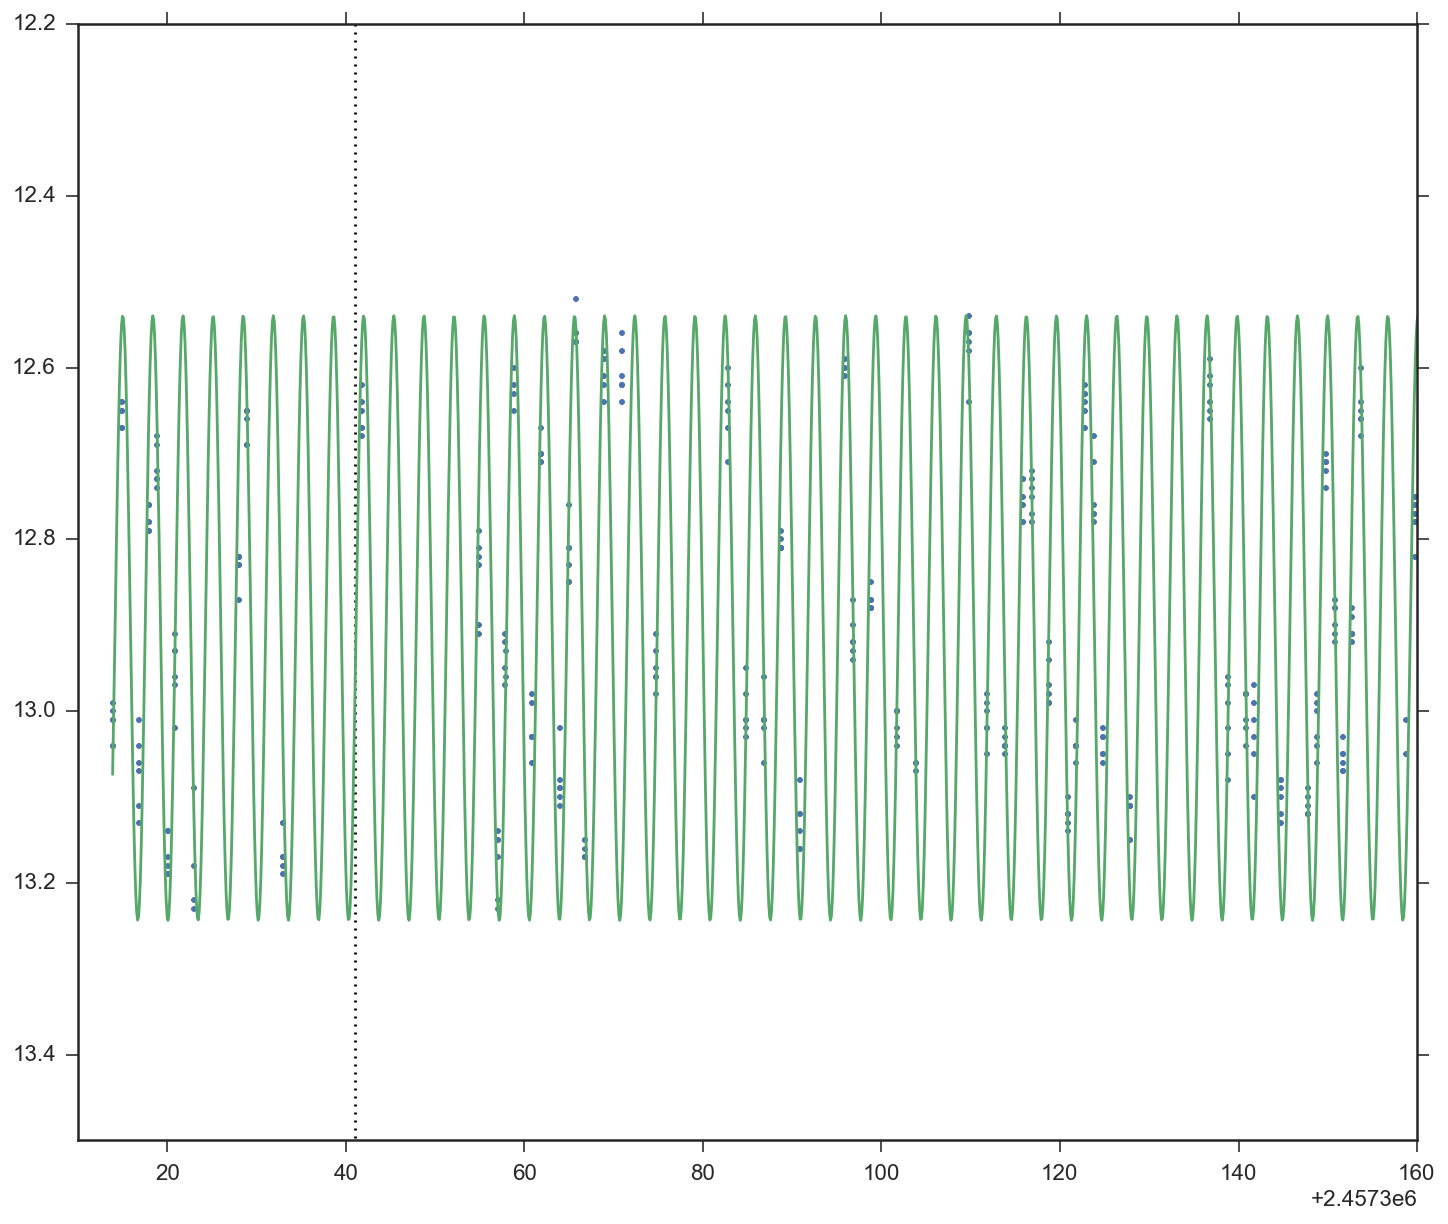

In [242]:
plt.figure(figsize=(12, 10))
plt.plot(dat.JD, dat.mag, '.')
plt.ylim(13.5, 12.2)
plt.xlim(2457310,2457310+150)#, 2457390)

plt.vlines(2457341.0, 12.2, 13.5, linestyles='dotted')

plt.plot(x_dense, model)

In [25]:
p = 3.374

In [26]:
phased = np.mod(x, p)

In [27]:
phased_IG = np.mod(2457344.8609722229, p)

In [33]:
y.shape

(445,)

In [38]:
dat.UT_date[inds].values[0], dat.UT_date[inds].values[-1]

('2015-02-12.2863084', '2016-03-12.2310206')

In [41]:
sns.set_context('talk')

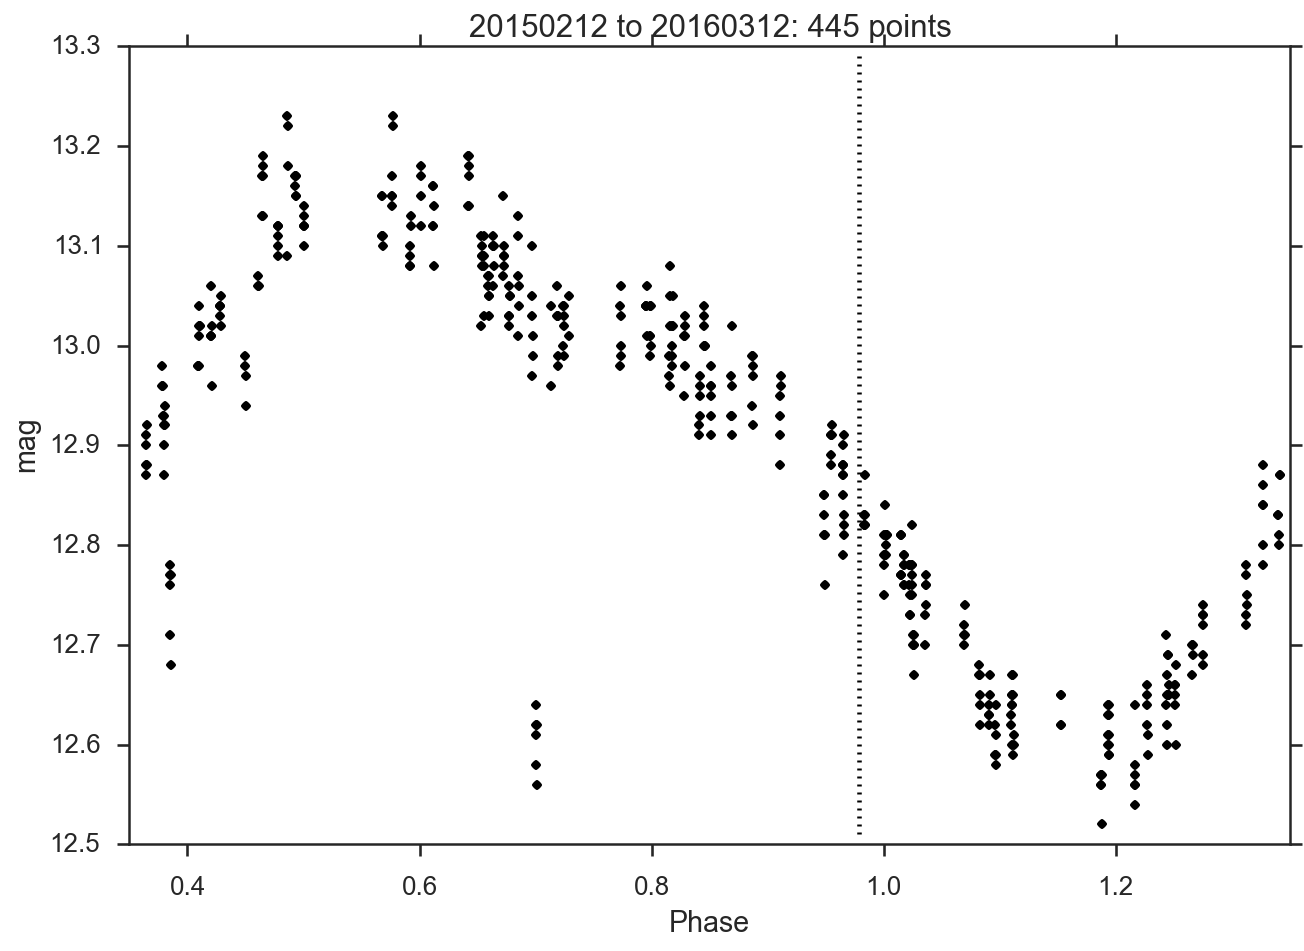

In [53]:
plt.plot(phased/p, y, 'k.')
plt.plot(phased/p+1.0, y, 'k.')
plt.vlines(phased_IG/p, 12.51, 13.29, linestyles='dotted')
plt.xlabel('Phase')
plt.ylabel('mag')
plt.title('20150212 to 20160312: 445 points')
plt.xlim(0.35, 1.35)
plt.savefig('../results/fig/phase_folded_lightcurve.pdf')

In [250]:
from astroML.time_series import multiterm_periodogram

In [267]:
periods = np.linspace(3.35, 3.40, 100)

In [268]:
omega = 2.00*np.pi/periods

In [269]:
P_M = multiterm_periodogram(x, y, yerr, omega)

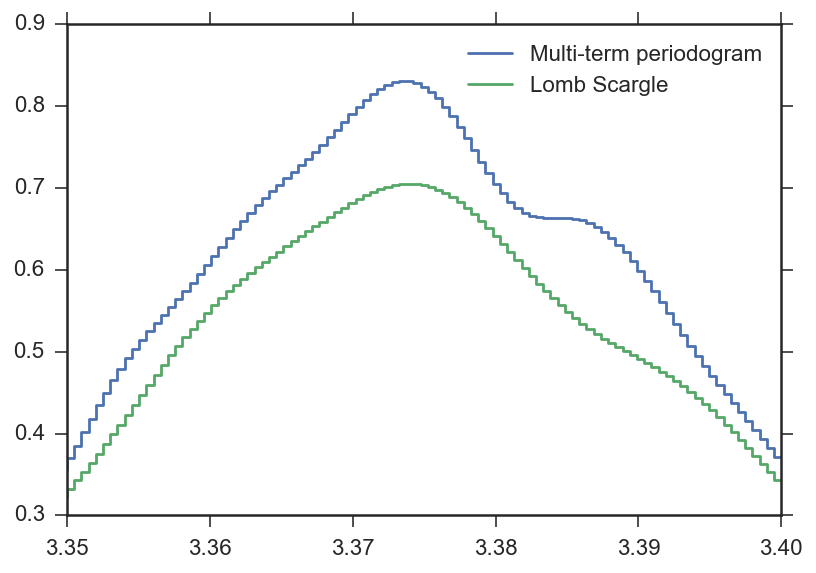

In [315]:
plt.step(periods, P_M, label='Multi-term periodogram')
plt.step(periods, P_LS, label='Lomb Scargle')
plt.legend()

In [272]:
from astroML.time_series import lomb_scargle

In [273]:
P_LS = lomb_scargle(x, y, yerr, omega)

In [278]:
np.argmax(P_LS), np.argmax(P_M)

(48, 47)

In [281]:
periods[48]

3.374242424242424

In [276]:
import astroML.time_series

In [282]:
mtf = astroML.time_series.MultiTermFit(3.374, 4)

In [284]:
mtf_fit = mtf.fit(x, y, yerr)

In [ ]:
mtf_fit.

In [292]:
phz, yfit = mtf.predict(100)

The end.